In [209]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import ipywidgets as wg
from IPython.display import display

from planetmagfields import planet
from planetmagfields.libbfield import getBr as calcBr

In [210]:
##### General Constants #######

# Actuator Information
e_thruster_array_mass = 0.234

# ScienceCraft Constants
boom_mass = 6
boom_length = 32.5
additional_boom_end_mass = e_thruster_array_mass * 2

Iz = (4 * ((boom_mass * boom_length ** 2 / 3) + (additional_boom_end_mass * boom_length ** 2)))
Ix = Iz / 2
Iy = Iz / 2

I = np.array([Ix, Iy, Iz]) # A vector representing the moment of inertia about the 3 axes

t = np.arange(0, 2.16e5, 1)

In [211]:
# Gravity gradient disturbances constants

# Relevant constants
G = 6.6743e-11

triton_mass = 2.1390e22

mu_neptune = 6.836529e15
mu_triton = G * triton_mass

# Radii of Neptune and Triton
r_neptune = 2.4622e7
r_triton = 1.35e6

# Distance from Neptune and Triton
R_neptune = np.array([4e9, 2e8]) + r_neptune # distance range from furthest to closest
R_triton = np.array([4e9, 3e6]) + r_triton

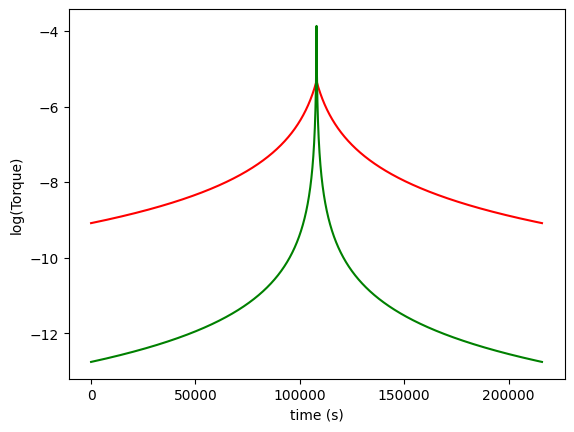

In [212]:
# Time series distances for Neptune and Triton
Rt_neptune = np.linspace(*R_neptune, int(t.size/2))
Rt_neptune = np.concatenate((Rt_neptune, np.flip(Rt_neptune)))

Rt_triton = np.linspace(*R_triton, int(t.size/2))
Rt_triton = np.concatenate((Rt_triton, np.flip(Rt_triton)))

# Function for calculating the gravity gardient disturbance torque
def Tg(R, mu, I):
	Ix, Iy, Iz = I
	coeff = (3 * mu) / (2 * R ** 3)
	Tg = np.abs(Iz - Iy) * coeff
	return Tg

Tg_neptune = np.vectorize(lambda R: Tg(R, mu_neptune, I))(Rt_neptune)
Tg_triton = np.vectorize(lambda R: Tg(R, mu_triton, I))(Rt_triton)


# Plotting the gravitational disturbance torque from Neptune and Triton relative to each other
plt.plot(t, np.log10(Tg_neptune), color="red")
plt.plot(t, np.log10(Tg_triton), color="green")
plt.xlabel("time (s)")
plt.ylabel("log(Torque)")
plt.show()


Planet: Neptune
l_max = 3
Dipole tilt (degrees) = 46.900530
0.0346420464788552
cartopy library not available, using Hammer projection


TypeError: getBr() got an unexpected keyword argument 'datDir'

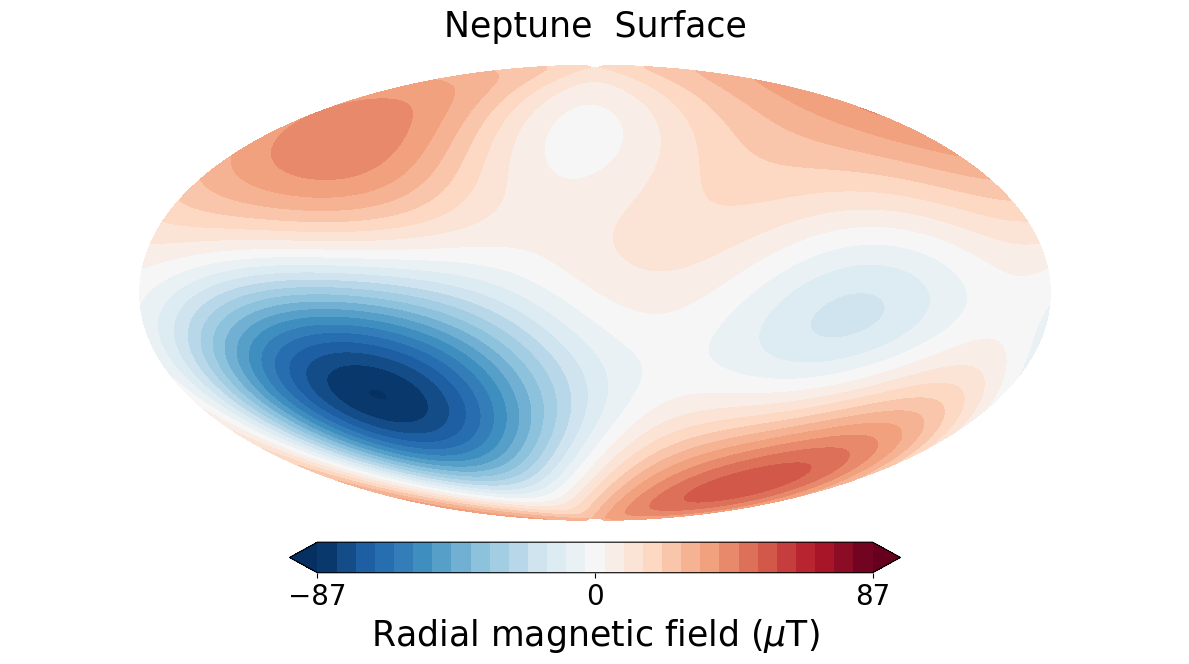

<Figure size 1200x675 with 0 Axes>

In [213]:
# Magnetic Field Disturbance Torque Calculation
neptune = planet(name="neptune", datDir="planetmagfields/data/")
R = 3123123123
r = R_neptune[1] / r_neptune 
_, _, Br, _, _ = calcBr(planet=neptune, r=r, info=False)
print(np.max(Br)) # Maximum magnetic field strength at a distance R from the center of mass of neptune
neptune.plot()
neptune.plot(r=r)
print(np.max(neptune.Br))